In [80]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.geocoders import Nominatim
from shapely.geometry import LineString
from shapely.geometry import Point
import matplotlib.lines as mlines

## Step 1: Net difference in migration to represent undirected graph - the data we will work with 
Every dataset will have COUNTRY OF INTEREST. 

- Difference = positive --> There is more people coming INTO the country
- Difference = negative --> There is more peopel LEAVING the country. 

### Implement by using USA

In [69]:
both_gender = pd.read_csv('data/both_gender.csv')
both_gender['1960'] = pd.to_numeric(both_gender['1960'], errors='coerce').fillna(0).astype(int)
both_gender['1970'] = pd.to_numeric(both_gender['1970'], errors='coerce').fillna(0).astype(int)
both_gender['1980'] = pd.to_numeric(both_gender['1980'], errors='coerce').fillna(0).astype(int)
both_gender['1990'] = pd.to_numeric(both_gender['1990'], errors='coerce').fillna(0).astype(int)
both_gender['2000'] = pd.to_numeric(both_gender['2000'], errors='coerce').fillna(0).astype(int)
both_gender.columns = ["Origin_name",	"Origin_code", 	"Gender_Code",	"Destination_name",	"Destination_code",	"1960",	"1970",	"1980",	"1990",	"2000"]
both_gender


,Origin_name,Origin_code,Gender_Code,Destination_name,Destination_code,1960,1970,1980,1990,2000
0,Afghanistan,AFG,TOT,Afghanistan,AFG,0,0,0,0,0
1,Afghanistan,AFG,TOT,Albania,ALB,0,0,0,0,0
2,Afghanistan,AFG,TOT,Algeria,DZA,41,16,13,10,8
3,Afghanistan,AFG,TOT,American Samoa,ASM,0,0,0,0,0
4,Afghanistan,AFG,TOT,Andorra,AND,0,0,2,5,6
...,...,...,...,...,...,...,...,...,...,...
53587,Zimbabwe,ZWE,TOT,Wallis and Futuna,WLF,0,0,0,0,0
53588,Zimbabwe,ZWE,TOT,West Bank and Gaza,PSE,0,0,0,0,0
53589,Zimbabwe,ZWE,TOT,"Yemen, Rep.",YEM,0,0,0,0,0
53590,Zimbabwe,ZWE,TOT,Zambia,ZMB,90416,72452,49691,34855,31538


In [70]:
both_gender_bothway = both_gender.merge(both_gender, left_on = 'Destination_code', right_on = 'Origin_code')
both_gender_bothway = both_gender_bothway[both_gender_bothway['Origin_code_x'] == both_gender_bothway['Destination_code_y']]
both_gender_bothway = both_gender_bothway[both_gender_bothway['Origin_code_x'] != both_gender_bothway['Origin_code_y']]
both_gender_bothway

,Origin_name_x,Origin_code_x,Gender_Code_x,Destination_name_x,Destination_code_x,1960_x,1970_x,1980_x,1990_x,2000_x,Origin_name_y,Origin_code_y,Gender_Code_y,Destination_name_y,Destination_code_y,1960_y,1970_y,1980_y,1990_y,2000_y
231,Afghanistan,AFG,TOT,Albania,ALB,0,0,0,0,0,Albania,ALB,TOT,Afghanistan,AFG,0,0,0,3,0
462,Afghanistan,AFG,TOT,Algeria,DZA,41,16,13,10,8,Algeria,DZA,TOT,Afghanistan,AFG,7,30,17,33,54
693,Afghanistan,AFG,TOT,American Samoa,ASM,0,0,0,0,0,American Samoa,ASM,TOT,Afghanistan,AFG,0,0,0,1,0
924,Afghanistan,AFG,TOT,Andorra,AND,0,0,2,5,6,Andorra,AND,TOT,Afghanistan,AFG,0,0,0,0,0
1155,Afghanistan,AFG,TOT,Angola,AGO,0,0,0,0,0,Angola,AGO,TOT,Afghanistan,AFG,0,4,2,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12378596,Zimbabwe,ZWE,TOT,"Virgin Islands, British",VGB,0,0,0,0,0,"Virgin Islands, British",VGB,TOT,Zimbabwe,ZWE,0,0,0,0,0
12378827,Zimbabwe,ZWE,TOT,Wallis and Futuna,WLF,0,0,0,0,0,Wallis and Futuna,WLF,TOT,Zimbabwe,ZWE,0,0,0,0,0
12379058,Zimbabwe,ZWE,TOT,West Bank and Gaza,PSE,0,0,0,0,0,West Bank and Gaza,PSE,TOT,Zimbabwe,ZWE,2,2,2,2,2
12379289,Zimbabwe,ZWE,TOT,"Yemen, Rep.",YEM,0,0,0,0,0,"Yemen, Rep.",YEM,TOT,Zimbabwe,ZWE,1,2,2,2,1


In [71]:
both_gender_bothway = both_gender_bothway[['Origin_name_x', 'Origin_code_x', 'Destination_name_x', 'Destination_code_x', 'Destination_name_y', 'Destination_code_y', '1960_x', '1970_x', '1980_x', '1990_x', '2000_x', '1960_y', '1970_y', '1980_y', '1990_y', '2000_y' ]]
both_gender_bothway.columns = ['Country_interest', 'Country_interest_code', 'Intermediate_country', 'Intermediate_country_code', 'Destination_name_y', 'Destination_code_y', '1960_leave', '1970_leave', '1980_leave', '1990_leave', '2000_leave', '1960_into', '1970_into', '1980_into', '1990_into', '2000_into' ]
both_gender_bothway

,Country_interest,Country_interest_code,Intermediate_country,Intermediate_country_code,Destination_name_y,Destination_code_y,1960_leave,1970_leave,1980_leave,1990_leave,2000_leave,1960_into,1970_into,1980_into,1990_into,2000_into
231,Afghanistan,AFG,Albania,ALB,Afghanistan,AFG,0,0,0,0,0,0,0,0,3,0
462,Afghanistan,AFG,Algeria,DZA,Afghanistan,AFG,41,16,13,10,8,7,30,17,33,54
693,Afghanistan,AFG,American Samoa,ASM,Afghanistan,AFG,0,0,0,0,0,0,0,0,1,0
924,Afghanistan,AFG,Andorra,AND,Afghanistan,AFG,0,0,2,5,6,0,0,0,0,0
1155,Afghanistan,AFG,Angola,AGO,Afghanistan,AFG,0,0,0,0,0,0,4,2,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12378596,Zimbabwe,ZWE,"Virgin Islands, British",VGB,Zimbabwe,ZWE,0,0,0,0,0,0,0,0,0,0
12378827,Zimbabwe,ZWE,Wallis and Futuna,WLF,Zimbabwe,ZWE,0,0,0,0,0,0,0,0,0,0
12379058,Zimbabwe,ZWE,West Bank and Gaza,PSE,Zimbabwe,ZWE,0,0,0,0,0,2,2,2,2,2
12379289,Zimbabwe,ZWE,"Yemen, Rep.",YEM,Zimbabwe,ZWE,0,0,0,0,0,1,2,2,2,1


In [72]:
series = both_gender_bothway['1960_into']#.sub(both_gender_bothway['1960_leave'], fill_value=0)
series

231             0
462             7
693             0
924             0
1155            0
            ...  
12378596        0
12378827        0
12379058        2
12379289        1
12379520    43465
Name: 1960_into, Length: 53130, dtype: int32

In [73]:
## Create the distnace column  (peopel coming in - people leaving coutry of interest)
both_gender_bothway['1960_difference'] = both_gender_bothway['1960_into'].sub(both_gender_bothway['1960_leave'], fill_value=0)
both_gender_bothway['1970_difference'] = both_gender_bothway['1970_into'] - both_gender_bothway['1970_leave']
both_gender_bothway['1980_difference'] = both_gender_bothway['1980_into'] - both_gender_bothway['1980_leave']
both_gender_bothway['1990_difference'] = both_gender_bothway['1990_into'] - both_gender_bothway['1990_leave']
both_gender_bothway['2000_difference'] = both_gender_bothway['2000_into'] - both_gender_bothway['2000_leave']
both_gender_bothway

C:\Users\Luna\AppData\Local\Temp\ipykernel_17924\2342366853.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_gender_bothway['1960_difference'] = both_gender_bothway['1960_into'].sub(both_gender_bothway['1960_leave'], fill_value=0)
C:\Users\Luna\AppData\Local\Temp\ipykernel_17924\2342366853.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both_gender_bothway['1970_difference'] = both_gender_bothway['1970_into'] - both_gender_bothway['1970_leave']
C:\Users\Luna\AppData\Local\Temp\ipykernel_17924\23

,Country_interest,Country_interest_code,Intermediate_country,Intermediate_country_code,Destination_name_y,Destination_code_y,1960_leave,1970_leave,1980_leave,1990_leave,...,1960_into,1970_into,1980_into,1990_into,2000_into,1960_difference,1970_difference,1980_difference,1990_difference,2000_difference
231,Afghanistan,AFG,Albania,ALB,Afghanistan,AFG,0,0,0,0,...,0,0,0,3,0,0,0,0,3,0
462,Afghanistan,AFG,Algeria,DZA,Afghanistan,AFG,41,16,13,10,...,7,30,17,33,54,-34,14,4,23,46
693,Afghanistan,AFG,American Samoa,ASM,Afghanistan,AFG,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
924,Afghanistan,AFG,Andorra,AND,Afghanistan,AFG,0,0,2,5,...,0,0,0,0,0,0,0,-2,-5,-6
1155,Afghanistan,AFG,Angola,AGO,Afghanistan,AFG,0,0,0,0,...,0,4,2,4,7,0,4,2,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12378596,Zimbabwe,ZWE,"Virgin Islands, British",VGB,Zimbabwe,ZWE,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12378827,Zimbabwe,ZWE,Wallis and Futuna,WLF,Zimbabwe,ZWE,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12379058,Zimbabwe,ZWE,West Bank and Gaza,PSE,Zimbabwe,ZWE,0,0,0,0,...,2,2,2,2,2,2,2,2,2,2
12379289,Zimbabwe,ZWE,"Yemen, Rep.",YEM,Zimbabwe,ZWE,0,0,0,0,...,1,2,2,2,1,1,2,2,2,1


### Prepare the dataset for America across all time periods

In [75]:
USA_df = both_gender_bothway[both_gender_bothway['Country_interest_code'] == 'USA']
USA_df

,Country_interest,Country_interest_code,Intermediate_country,Intermediate_country_code,Destination_name_y,Destination_code_y,1960_leave,1970_leave,1980_leave,1990_leave,...,1960_into,1970_into,1980_into,1990_into,2000_into,1960_difference,1970_difference,1980_difference,1990_difference,2000_difference
11686277,United States,USA,Afghanistan,AFG,United States,USA,14,17,35,92,...,293,207,4832,30146,44893,279,190,4797,30054,44747
11686508,United States,USA,Albania,ALB,United States,USA,10,11,13,14,...,10047,10865,7963,5844,40555,10037,10854,7950,5830,40539
11686739,United States,USA,Algeria,DZA,United States,USA,141,55,43,34,...,322,533,4843,5577,11717,181,478,4800,5543,11690
11686970,United States,USA,American Samoa,ASM,United States,USA,259,1122,2214,3533,...,2519,11528,9604,1870,16339,2260,10406,7390,-1663,12734
11687201,United States,USA,Andorra,AND,United States,USA,3,14,37,73,...,440,3,1548,57,5,437,-11,1511,-16,-90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11738483,United States,USA,Wallis and Futuna,WLF,United States,USA,0,0,0,1,...,0,0,0,0,0,0,0,0,-1,-4
11738714,United States,USA,West Bank and Gaza,PSE,United States,USA,14341,17098,20243,26637,...,31,0,11,21189,0,-14310,-17098,-20232,-5448,-41175
11738945,United States,USA,"Yemen, Rep.",YEM,United States,USA,1162,1439,1781,2205,...,184,145,3385,6218,19762,-978,-1294,1604,4013,17184
11739176,United States,USA,Zambia,ZMB,United States,USA,950,761,1977,619,...,181,405,1952,3886,10804,-769,-356,-25,3267,10244


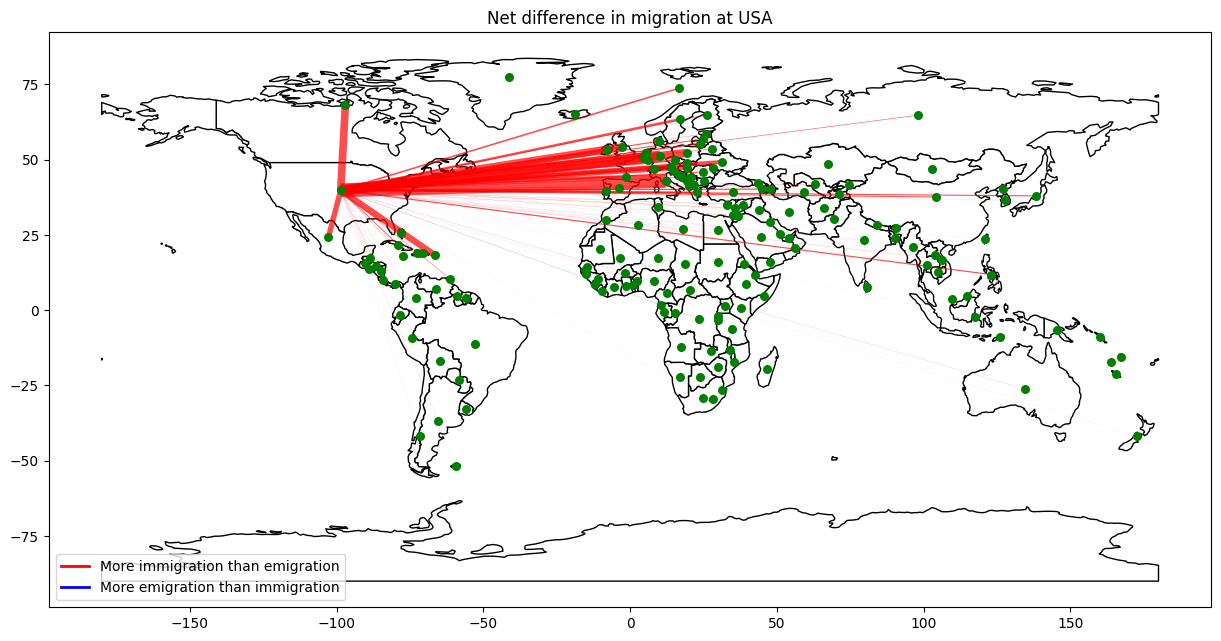

In [83]:
# Load world map from GeoPandas
# Assuming you have your migration graph already created (G is your directed graph)

# Load the world map from a custom shapefile
shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Make sure ISO codes match your dataset’s format
# For example, if your codes are uppercase like "AFG", ensure the shapefile codes are too
world['ADM0_A3'] = world['ADM0_A3'].str.upper()

# Create a column with centroid geometry for each country polygon
# This yields a Point geometry representing the centroid of the country
world_proj = world.to_crs(epsg=3857)

# 3. Calculate centroids in the projected CRS
world_proj['centroid'] = world_proj.geometry.centroid

# 4. Convert the centroids back to lat-lon
#    We switch the GeoDataFrame to use the 'centroid' column as its geometry
world_proj = world_proj.set_geometry('centroid')
world_proj = world_proj.to_crs(epsg=4326)

# 5. Now 'world_proj.geometry' holds centroid points in lat-lon. 
#    You can store them back in the original 'world' GeoDataFrame if you like:
world['centroid'] = world_proj.geometry
# Approximate center of the contiguous US
contig_us_center = Point(-98.58, 39.83)  # (lon, lat)

# Override the centroid for the USA row
world.loc[world['ADM0_A3'] == 'USA', 'centroid'] = contig_us_center

# 4.1: Merge df with world to get origin geometry
df_merged = USA_df.merge(
    world[['ADM0_A3', 'centroid']], 
    left_on='Country_interest_code', 
    right_on='ADM0_A3', 
    how='left'
)

# Rename the centroid column to something like origin_centroid
df_merged = df_merged.rename(columns={'centroid': 'origin_centroid'})
df_merged.drop(columns='ADM0_A3', inplace=True)

# 4.2: Merge again to get destination geometry
df_merged = df_merged.merge(
    world[['ADM0_A3', 'centroid']], 
    left_on='Intermediate_country_code', 
    right_on='ADM0_A3', 
    how='left'
)
df_merged = df_merged.rename(columns={'centroid': 'destination_centroid'})
df_merged.drop(columns='ADM0_A3', inplace=True)

df_merged = df_merged[df_merged['origin_centroid'] != None]


def create_linestring(row):
    # row['origin_centroid'] and row['destination_centroid'] are Shapely Points
    orig_point = row['origin_centroid']
    dest_point = row['destination_centroid']
    
    # If either is NaN or missing, return None
    if pd.isnull(orig_point) or pd.isnull(dest_point):
        return None
    
    return LineString([orig_point, dest_point])

df_merged['geometry'] = df_merged.apply(create_linestring, axis=1)

# Drop rows where geometry is None
df_merged = df_merged.dropna(subset=['geometry'])

# Convert this DataFrame to a GeoDataFrame
gdf_edges = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")

# 1. Create an 'edge_color' column: blue if negative, red otherwise
gdf_edges['edge_color'] = gdf_edges['1960_difference'].apply(
    lambda x: 'blue' if x < 0 else 'red'
)

# 2. Scale line widths by the absolute value of 1960_difference
max_diff = gdf_edges['1960_difference'].abs().max()
scale_factor = 10.0 / max_diff  # tweak for desired thickness
gdf_edges['edge_width'] = gdf_edges['1960_difference'].abs() * scale_factor


# Plot setup
fig, ax = plt.subplots(figsize=(15,10))

# 6.1 Plot the world map
world.plot(ax=ax, color='white', edgecolor='black')

gdf_edges.plot(
    ax=ax,
    color=gdf_edges['edge_color'],
    linewidth=gdf_edges['edge_width'],
    alpha=0.7
)

# -- (Optional) ADD NODE MARKERS BELOW -- #
# We gather all unique origin and destination points in a separate GeoDataFrame
all_points = []

# Extract origin points
tmp_orig = df_merged[['Country_interest_code', 'origin_centroid']].drop_duplicates()
tmp_orig = tmp_orig.rename(columns={
    'Country_interest_code': 'country_code',
    'origin_centroid': 'geometry'
})
all_points.append(tmp_orig)

# Extract destination points
tmp_dest = df_merged[['Intermediate_country_code', 'destination_centroid']].drop_duplicates()
tmp_dest = tmp_dest.rename(columns={
    'Intermediate_country_code': 'country_code',
    'destination_centroid': 'geometry'
})
all_points.append(tmp_dest)

# Concatenate origin & destination points, drop duplicates
df_points = pd.concat(all_points).drop_duplicates('country_code')
# print(df_points)

# Make a GeoDataFrame
gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

# Finally, plot the points on top of the map and lines
gdf_points.plot(
    ax=ax,
    color='green',
    markersize=30,  # Adjust as desired
    zorder=4        # Ensures markers appear above the lines
)

# Create custom legend handles
red_line = mlines.Line2D([], [], color='red', linewidth=2, label='More immigration than emigration')
blue_line = mlines.Line2D([], [], color='blue', linewidth=2, label='More emigration than immigration')

# Add the legend to the plot (adjust loc as needed, e.g., 'upper right')
plt.legend(handles=[red_line, blue_line], loc='lower left')

plt.title("Net difference in migration at USA")
plt.show()


### Generalize to a function to create a graph

In [172]:
def visualize_map(original_df, country_code, country_name,time_column):
    country_code_df = original_df[original_df['Country_interest_code'] == country_code]

    # Load world map from GeoPandas
    # Assuming you have your migration graph already created (G is your directed graph)

    # Load the world map from a custom shapefile
    shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
    world = gpd.read_file(shapefile_path)

    # Make sure ISO codes match your dataset’s format
    # For example, if your codes are uppercase like "AFG", ensure the shapefile codes are too
    world['ADM0_A3'] = world['ADM0_A3'].str.upper()

    # Create a column with centroid geometry for each country polygon
    # This yields a Point geometry representing the centroid of the country
    world_proj = world.to_crs(epsg=3857)

    # 3. Calculate centroids in the projected CRS
    world_proj['centroid'] = world_proj.geometry.centroid

    # 4. Convert the centroids back to lat-lon
    #    We switch the GeoDataFrame to use the 'centroid' column as its geometry
    world_proj = world_proj.set_geometry('centroid')
    world_proj = world_proj.to_crs(epsg=4326)

    # 5. Now 'world_proj.geometry' holds centroid points in lat-lon. 
    #    You can store them back in the original 'world' GeoDataFrame if you like:
    world['centroid'] = world_proj.geometry
    # Approximate center of the contiguous US
    contig_us_center = Point(-98.58, 39.83)  # (lon, lat)

    # Override the centroid for the USA row
    world.loc[world['ADM0_A3'] == 'USA', 'centroid'] = contig_us_center
    world.loc[world['ADM0_A3'] == 'CHN', 'centroid'] = Point(104.1954, 35.8617)

    ## For palestine, the code is encoded differently
    world['ADM0_A3'] = world['ADM0_A3'].replace('PSX', 'PSE')

    # 4.1: Merge df with world to get origin geometry
    df_merged = country_code_df.merge(
        world[['ADM0_A3', 'centroid']], 
        left_on='Country_interest_code', 
        right_on='ADM0_A3', 
        how='left'
    )

    # Rename the centroid column to something like origin_centroid
    df_merged = df_merged.rename(columns={'centroid': 'origin_centroid'})
    df_merged.drop(columns='ADM0_A3', inplace=True)

    # 4.2: Merge again to get destination geometry
    df_merged = df_merged.merge(
        world[['ADM0_A3', 'centroid']], 
        left_on='Intermediate_country_code', 
        right_on='ADM0_A3', 
        how='left'
    )
    df_merged = df_merged.rename(columns={'centroid': 'destination_centroid'})
    df_merged.drop(columns='ADM0_A3', inplace=True)

    df_merged = df_merged[df_merged['origin_centroid'] != None]


    def create_linestring(row):
        # row['origin_centroid'] and row['destination_centroid'] are Shapely Points
        orig_point = row['origin_centroid']
        dest_point = row['destination_centroid']
        
        # If either is NaN or missing, return None
        if pd.isnull(orig_point) or pd.isnull(dest_point):
            return None
        
        return LineString([orig_point, dest_point])

    df_merged['geometry'] = df_merged.apply(create_linestring, axis=1)

    # Drop rows where geometry is None
    df_merged = df_merged.dropna(subset=['geometry'])

    # Convert this DataFrame to a GeoDataFrame
    gdf_edges = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")

    # 1. Create an 'edge_color' column: blue if negative, red otherwise
    gdf_edges['edge_color'] = gdf_edges[time_column].apply(
        lambda x: 'blue' if x < 0 else 'red'
    )

    # 2. Scale line widths by the absolute value of 1960_difference
    max_diff = gdf_edges[time_column].abs().max()
    scale_factor = 10.0 / max_diff  # tweak for desired thickness
    gdf_edges['edge_width'] = gdf_edges[time_column].abs() * scale_factor
    # print(df_merged.shape)



    # Plot setup
    fig, ax = plt.subplots(figsize=(15,10))

    # 6.1 Plot the world map
    world.plot(ax=ax, color='white', edgecolor='black')

    gdf_edges.plot(
        ax=ax,
        color=gdf_edges['edge_color'],
        linewidth=gdf_edges['edge_width'],
        alpha=0.7
    )

    # -- (Optional) ADD NODE MARKERS BELOW -- #
    # We gather all unique origin and destination points in a separate GeoDataFrame
    all_points = []

    # Extract origin points
    tmp_orig = df_merged[['Country_interest_code', 'origin_centroid']].drop_duplicates()
    tmp_orig = tmp_orig.rename(columns={
        'Country_interest_code': 'country_code',
        'origin_centroid': 'geometry'
    })
    all_points.append(tmp_orig)

    # Extract destination points
    tmp_dest = df_merged[['Intermediate_country_code', 'destination_centroid']].drop_duplicates()
    tmp_dest = tmp_dest.rename(columns={
        'Intermediate_country_code': 'country_code',
        'destination_centroid': 'geometry'
    })
    all_points.append(tmp_dest)

    # Concatenate origin & destination points, drop duplicates
    df_points = pd.concat(all_points).drop_duplicates('country_code')
    # print(df_points)

    # Make a GeoDataFrame
    gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

    # Finally, plot the points on top of the map and lines
    gdf_points.plot(
        ax=ax,
        color='green',
        markersize=30,  # Adjust as desired
        zorder=4        # Ensures markers appear above the lines
    )

    # Create custom legend handles
    red_line = mlines.Line2D([], [], color='red', linewidth=2, label='More immigration than emigration')
    blue_line = mlines.Line2D([], [], color='blue', linewidth=2, label='More emigration than immigration')

    # Add the legend to the plot (adjust loc as needed, e.g., 'upper right')
    plt.legend(handles=[red_line, blue_line], loc='lower left')

    plt.title(f"Net difference in migration at {country_name} at year {time_column[:4]}")
    plt.show()

    

    

In [173]:
both_gender_bothway[both_gender_bothway['Country_interest_code'] == 'PSE']

,Country_interest,Country_interest_code,Intermediate_country,Intermediate_country_code,Destination_name_y,Destination_code_y,1960_leave,1970_leave,1980_leave,1990_leave,...,1960_into,1970_into,1980_into,1990_into,2000_into,1960_difference,1970_difference,1980_difference,1990_difference,2000_difference
12166535,West Bank and Gaza,PSE,Afghanistan,AFG,West Bank and Gaza,PSE,0,0,0,1,...,39,46,55,72,111,39,46,55,71,111
12166766,West Bank and Gaza,PSE,Albania,ALB,West Bank and Gaza,PSE,0,0,0,0,...,17,20,24,31,48,17,20,24,31,48
12166997,West Bank and Gaza,PSE,Algeria,DZA,West Bank and Gaza,PSE,1042,409,322,254,...,3293,3926,4648,6116,9454,2251,3517,4326,5862,9254
12167228,West Bank and Gaza,PSE,American Samoa,ASM,West Bank and Gaza,PSE,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12167459,West Bank and Gaza,PSE,Andorra,AND,West Bank and Gaza,PSE,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12218510,West Bank and Gaza,PSE,"Virgin Islands, British",VGB,West Bank and Gaza,PSE,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12218741,West Bank and Gaza,PSE,Wallis and Futuna,WLF,West Bank and Gaza,PSE,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12219203,West Bank and Gaza,PSE,"Yemen, Rep.",YEM,West Bank and Gaza,PSE,424,525,651,805,...,2527,3012,3567,4693,7255,2103,2487,2916,3888,6314
12219434,West Bank and Gaza,PSE,Zambia,ZMB,West Bank and Gaza,PSE,0,0,4,0,...,0,0,0,0,0,0,0,-4,0,0


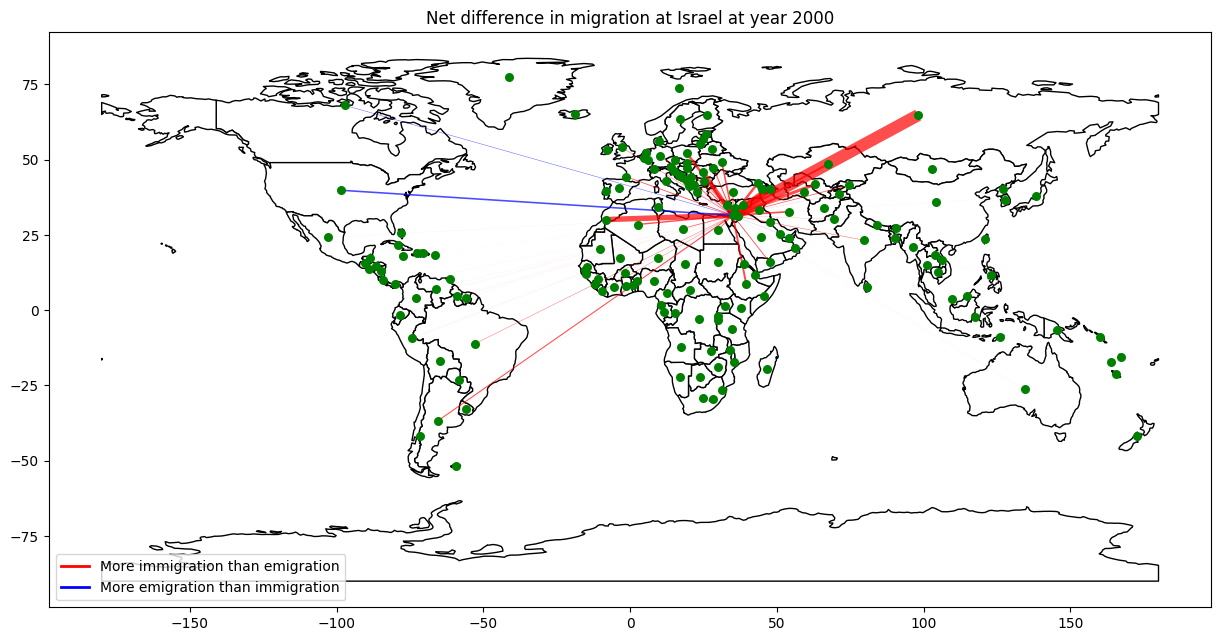

In [182]:
visualize_map(both_gender_bothway, 'ISR', 'Israel', '2000_difference')

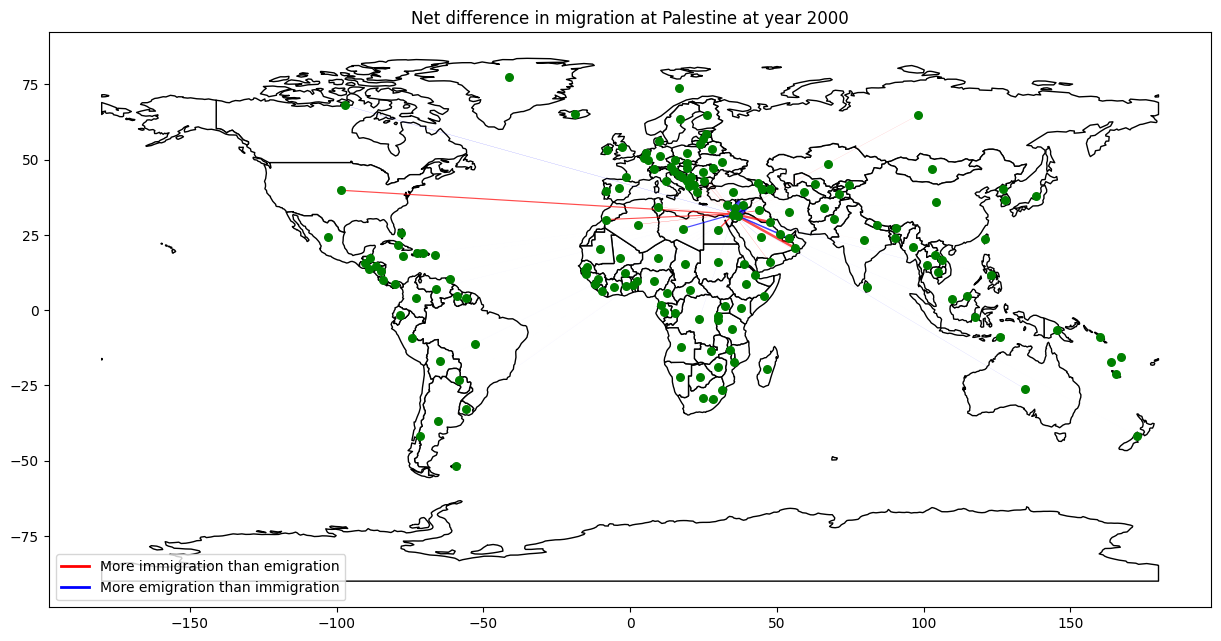

In [183]:
visualize_map(both_gender_bothway, 'PSE', 'Palestine', '2000_difference')

## Country of interest - DO BY TONIGHT, SAT MORNING
Instruction: Create a visualization for undirected graph for each country for each time frame. 
- USA
- China
- Cuba
- Vietnam
- Combodian
- Israel-Palestine: Middle East 
    - Israel to world    ISR - Israel
    - Palestine to world  PSE - West Bank and Gaza
    - Comparison to see which country is more accepting, or not

### Prepare the dataset for China across all time periods

### Prepare the dataset for America across all time periods

In [2]:
def get_coordinates(country_name):
    geolocator = Nominatim(user_agent="migration_map")
    
    try:
        location = geolocator.geocode(country_name)
        if location:
            return location.latitude, location.longitude
        else:
            # If the country is not found, return None (or handle it differently)
            return None
    except Exception as e:
        print(f"Error retrieving coordinates for {country_name}: {e}")
        return None


In [3]:
both_gender_1960 = pd.read_csv('data/both_gender/1960.csv')[["Origin_name",	"Origin_code","Destination_name","Destination_code","1960"]]
both_gender_1960['1960'] = pd.to_numeric(both_gender_1960['1960'], errors='coerce').fillna(0).astype(int)
both_gender_1960 = both_gender_1960[both_gender_1960['1960'] != 0]
both_gender_1960

,Origin_name,Origin_code,Destination_name,Destination_code,1960
2,Afghanistan,AFG,Algeria,DZA,41
8,Afghanistan,AFG,Argentina,ARG,6
11,Afghanistan,AFG,Australia,AUS,42
12,Afghanistan,AFG,Austria,AUT,47
15,Afghanistan,AFG,Bahrain,BHR,62
...,...,...,...,...,...
53563,Zimbabwe,ZWE,Tanzania,TZA,1415
53575,Zimbabwe,ZWE,Uganda,UGA,5
53578,Zimbabwe,ZWE,United Kingdom,GBR,176
53579,Zimbabwe,ZWE,United States,USA,331


## Looking just at UNITED STATES

In [4]:
US_df = both_gender_1960[(both_gender_1960['Origin_name'] == "United States") |(both_gender_1960['Destination_name'] == "United States")]
US_df

,Origin_name,Origin_code,Destination_name,Destination_code,1960
218,Afghanistan,AFG,United States,USA,293
449,Albania,ALB,United States,USA,10047
680,Algeria,DZA,United States,USA,322
911,American Samoa,ASM,United States,USA,2519
1142,Andorra,AND,United States,USA,440
...,...,...,...,...,...
52424,"Virgin Islands, British",VGB,United States,USA,356
52886,West Bank and Gaza,PSE,United States,USA,31
53117,"Yemen, Rep.",YEM,United States,USA,184
53348,Zambia,ZMB,United States,USA,181


In [5]:
US_leave = US_df[US_df['Origin_name'] == "United States"]
US_to =  US_df[US_df['Destination_name'] == "United States"]
US_to

,Origin_name,Origin_code,Destination_name,Destination_code,1960
218,Afghanistan,AFG,United States,USA,293
449,Albania,ALB,United States,USA,10047
680,Algeria,DZA,United States,USA,322
911,American Samoa,ASM,United States,USA,2519
1142,Andorra,AND,United States,USA,440
...,...,...,...,...,...
52424,"Virgin Islands, British",VGB,United States,USA,356
52886,West Bank and Gaza,PSE,United States,USA,31
53117,"Yemen, Rep.",YEM,United States,USA,184
53348,Zambia,ZMB,United States,USA,181


In [6]:
# Create a directed graph
G_leave = nx.DiGraph()

# Add edges to the graph, with origin and destination as nodes
for _, row in US_leave.iterrows():
    G_leave.add_edge(row['Origin_name'], row['Destination_name'], weight=row['1960'])

KeyboardInterrupt: 

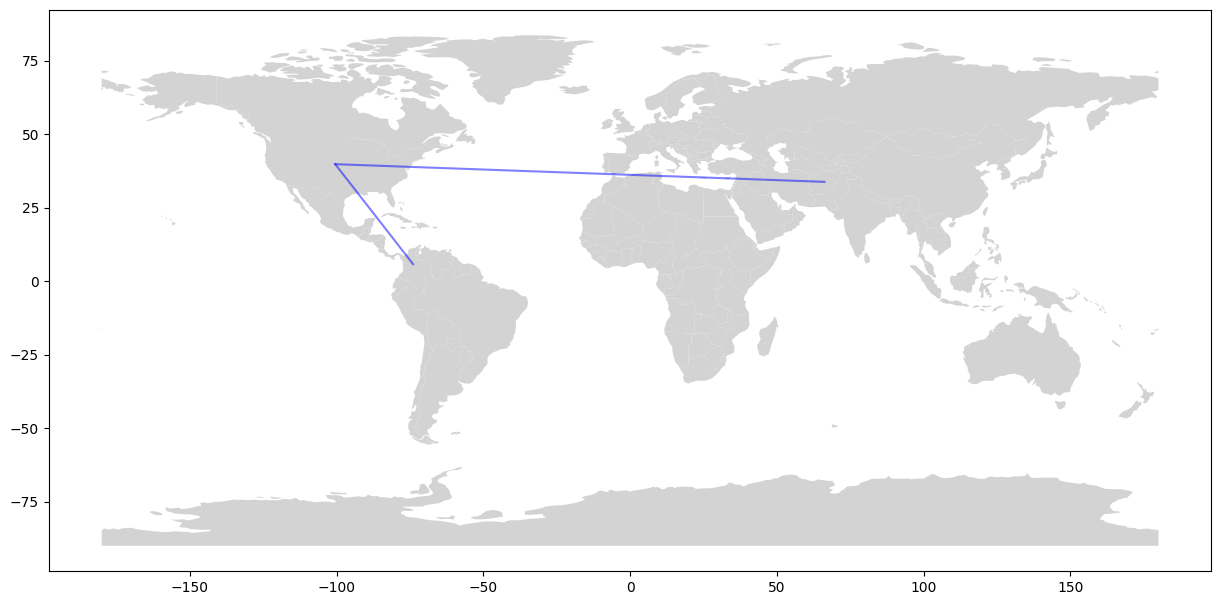

In [7]:
# Assuming you have your migration graph already created (G is your directed graph)

# Load the world map from a custom shapefile
shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Plot the world map
ax = world.plot(figsize=(15, 10), color='lightgrey')

# Add edges from the migration graph to the plot
for edge in G_leave.edges():
    origin, destination = edge
    origin_coords = get_coordinates(origin)
    destination_coords = get_coordinates(destination)
    
    if origin_coords and destination_coords:
        # Plot the line between the origin and destination on the map
        plt.plot([origin_coords[1], destination_coords[1]], 
                 [origin_coords[0], destination_coords[0]], color='blue', alpha=0.5)

# Show the plot
plt.title('Countries Leaving United States')
plt.show()


In [8]:
G_to = nx.from_pandas_edgelist(
    US_to,
    source='Origin_code',
    target='Destination_code',
    edge_attr='1960',
    create_using=nx.DiGraph()
)


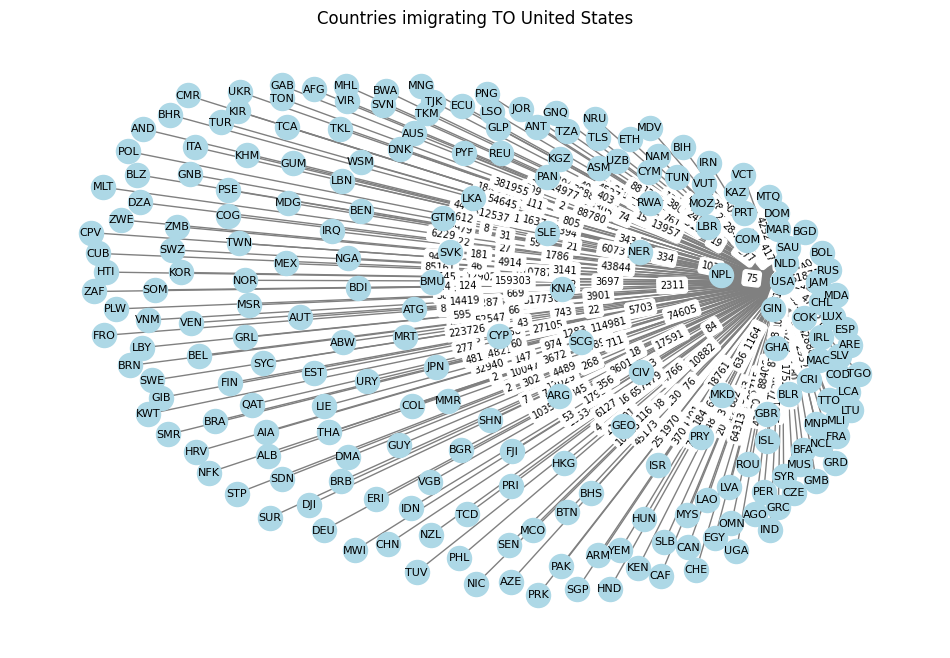

In [9]:
# Choose a layout
pos = nx.spring_layout(G_to, k=0.5, seed=42)

# Draw nodes and edges
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G_to, pos, node_size=300, node_color='lightblue')
nx.draw_networkx_edges(G_to, pos, arrowstyle='->', arrowsize=10, edge_color='gray')

# Draw labels for nodes
nx.draw_networkx_labels(G_to, pos, font_size=8)

# (Optional) Draw edge labels (the migration counts)
edge_labels = nx.get_edge_attributes(G_to, '1960')
nx.draw_networkx_edge_labels(G_to, pos, edge_labels=edge_labels, font_size=7)

plt.axis('off')
plt.title('Countries imigrating TO United States')
plt.show()


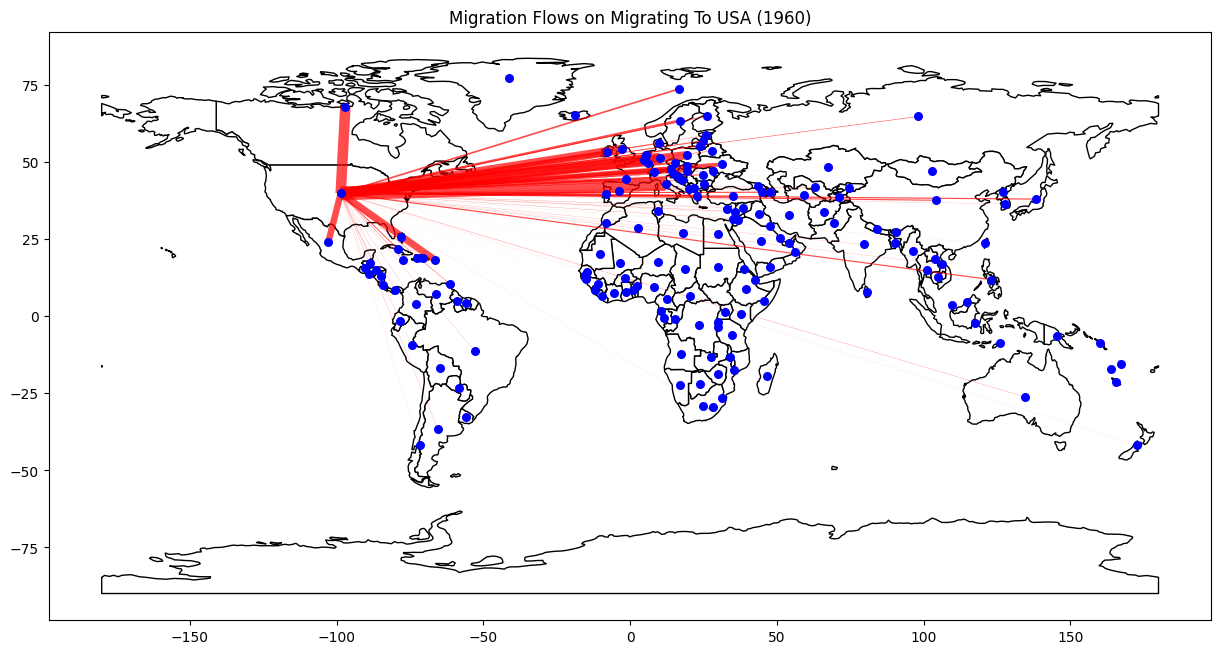

In [29]:
# Load world map from GeoPandas
# Assuming you have your migration graph already created (G is your directed graph)

# Load the world map from a custom shapefile
shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Make sure ISO codes match your dataset’s format
# For example, if your codes are uppercase like "AFG", ensure the shapefile codes are too
world['ADM0_A3'] = world['ADM0_A3'].str.upper()

# Create a column with centroid geometry for each country polygon
# This yields a Point geometry representing the centroid of the country
world_proj = world.to_crs(epsg=3857)

# 3. Calculate centroids in the projected CRS
world_proj['centroid'] = world_proj.geometry.centroid

# 4. Convert the centroids back to lat-lon
#    We switch the GeoDataFrame to use the 'centroid' column as its geometry
world_proj = world_proj.set_geometry('centroid')
world_proj = world_proj.to_crs(epsg=4326)

# 5. Now 'world_proj.geometry' holds centroid points in lat-lon. 
#    You can store them back in the original 'world' GeoDataFrame if you like:
world['centroid'] = world_proj.geometry
# Approximate center of the contiguous US
contig_us_center = Point(-98.58, 39.83)  # (lon, lat)

# Override the centroid for the USA row
world.loc[world['ADM0_A3'] == 'USA', 'centroid'] = contig_us_center

# 4.1: Merge df with world to get origin geometry
df_merged = US_to.merge(
    world[['ADM0_A3', 'centroid']], 
    left_on='Origin_code', 
    right_on='ADM0_A3', 
    how='left'
)

# Rename the centroid column to something like origin_centroid
df_merged = df_merged.rename(columns={'centroid': 'origin_centroid'})
df_merged.drop(columns='ADM0_A3', inplace=True)

# 4.2: Merge again to get destination geometry
df_merged = df_merged.merge(
    world[['ADM0_A3', 'centroid']], 
    left_on='Destination_code', 
    right_on='ADM0_A3', 
    how='left'
)
df_merged = df_merged.rename(columns={'centroid': 'destination_centroid'})
df_merged.drop(columns='ADM0_A3', inplace=True)

df_merged = df_merged[df_merged['origin_centroid'] != None]


def create_linestring(row):
    # row['origin_centroid'] and row['destination_centroid'] are Shapely Points
    orig_point = row['origin_centroid']
    dest_point = row['destination_centroid']
    
    # If either is NaN or missing, return None
    if pd.isnull(orig_point) or pd.isnull(dest_point):
        return None
    
    return LineString([orig_point, dest_point])

df_merged['geometry'] = df_merged.apply(create_linestring, axis=1)

# Drop rows where geometry is None
df_merged = df_merged.dropna(subset=['geometry'])

# Convert this DataFrame to a GeoDataFrame
gdf_edges = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")


# Plot setup
fig, ax = plt.subplots(figsize=(15,10))

# 6.1 Plot the world map
world.plot(ax=ax, color='white', edgecolor='black')

# For example, define a scale factor
max_migration = gdf_edges['1960'].max()
scale_factor = 10.0 / max_migration  # tweak to taste

gdf_edges.plot(
    ax=ax,
    color='red',
    linewidth=gdf_edges['1960'] * scale_factor,
    alpha=0.7
)

# -- (Optional) ADD NODE MARKERS BELOW -- #
# We gather all unique origin and destination points in a separate GeoDataFrame
all_points = []

# Extract origin points
tmp_orig = df_merged[['Origin_code', 'origin_centroid']].drop_duplicates()
tmp_orig = tmp_orig.rename(columns={
    'Origin_code': 'country_code',
    'origin_centroid': 'geometry'
})
all_points.append(tmp_orig)

# Extract destination points
tmp_dest = df_merged[['Destination_code', 'destination_centroid']].drop_duplicates()
tmp_dest = tmp_dest.rename(columns={
    'Destination_code': 'country_code',
    'destination_centroid': 'geometry'
})
all_points.append(tmp_dest)

# Concatenate origin & destination points, drop duplicates
df_points = pd.concat(all_points).drop_duplicates('country_code')
# print(df_points)

# Make a GeoDataFrame
gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

# Finally, plot the points on top of the map and lines
gdf_points.plot(
    ax=ax,
    color='blue',
    markersize=30,  # Adjust as desired
    zorder=4        # Ensures markers appear above the lines
)

plt.title("Migration Flows on Migrating To USA (1960)")
plt.show()


## Country of interest - DO BY TONIGHT, SAT MORNING
Instruction: Create a visualization for undirected graph for each country for each time frame. 
- USA
- China
- Cuba
- Vietnam
- Combodian
- Israel-Palestine: Middle East 
    - Israel to world    ISR - Israel
    - Palestine to world  PSE - West Bank and Gaza
    - Comparison to see which country is more accepting, or not

## Analyze(Later): Is the migration network random? is it scale-free?
THIS IS analysis with ALL the data combined. 

LOOK UP HOW randomness is determined with WEIGHTED graph.....

The graph is probably assortative. Look into proving that hypothesis

In [10]:
# Load world map from GeoPandas
# Assuming you have your migration graph already created (G is your directed graph)

# Load the world map from a custom shapefile
shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Make sure ISO codes match your dataset’s format
# For example, if your codes are uppercase like "AFG", ensure the shapefile codes are too
world['ADM0_A3'] = world['ADM0_A3'].str.upper()

# Create a column with centroid geometry for each country polygon
# This yields a Point geometry representing the centroid of the country
world_proj = world.to_crs(epsg=3857)

# 3. Calculate centroids in the projected CRS
world_proj['centroid'] = world_proj.geometry.centroid

# 4. Convert the centroids back to lat-lon
#    We switch the GeoDataFrame to use the 'centroid' column as its geometry
world_proj = world_proj.set_geometry('centroid')
world_proj = world_proj.to_crs(epsg=4326)

# 5. Now 'world_proj.geometry' holds centroid points in lat-lon. 
#    You can store them back in the original 'world' GeoDataFrame if you like:
world['centroid'] = world_proj.geometry

# world.to_csv("world_data.csv")
# world

In [11]:
# 4.1: Merge df with world to get origin geometry
df_merged = US_to.merge(
    world[['ADM0_A3', 'centroid']], 
    left_on='Origin_code', 
    right_on='ADM0_A3', 
    how='left'
)

# Rename the centroid column to something like origin_centroid
df_merged = df_merged.rename(columns={'centroid': 'origin_centroid'})
df_merged.drop(columns='ADM0_A3', inplace=True)

# 4.2: Merge again to get destination geometry
df_merged = df_merged.merge(
    world[['ADM0_A3', 'centroid']], 
    left_on='Destination_code', 
    right_on='ADM0_A3', 
    how='left'
)
df_merged = df_merged.rename(columns={'centroid': 'destination_centroid'})
df_merged.drop(columns='ADM0_A3', inplace=True)

df_merged = df_merged[df_merged['origin_centroid'] != None]
df_merged

,Origin_name,Origin_code,Destination_name,Destination_code,1960,origin_centroid,destination_centroid
0,Afghanistan,AFG,United States,USA,293,POINT (66.12826 33.93667),POINT (-119.45018 51.26001)
1,Albania,ALB,United States,USA,10047,POINT (20.03154 41.1538),POINT (-119.45018 51.26001)
2,Algeria,DZA,United States,USA,322,POINT (2.59661 28.44987),POINT (-119.45018 51.26001)
5,Angola,AGO,United States,USA,141,POINT (17.4732 -12.30289),POINT (-119.45018 51.26001)
8,Argentina,ARG,United States,USA,17591,POINT (-65.4182 -36.7045),POINT (-119.45018 51.26001)
...,...,...,...,...,...,...,...
210,"Venezuela, RB",VEN,United States,USA,7287,POINT (-66.1692 7.18082),POINT (-119.45018 51.26001)
211,Vietnam,VNM,United States,USA,14419,POINT (106.26223 16.82176),POINT (-119.45018 51.26001)
215,"Yemen, Rep.",YEM,United States,USA,184,POINT (47.54565 15.92826),POINT (-119.45018 51.26001)
216,Zambia,ZMB,United States,USA,181,POINT (27.71108 -13.42741),POINT (-119.45018 51.26001)


In [12]:
def create_linestring(row):
    # row['origin_centroid'] and row['destination_centroid'] are Shapely Points
    orig_point = row['origin_centroid']
    dest_point = row['destination_centroid']
    
    # If either is NaN or missing, return None
    if pd.isnull(orig_point) or pd.isnull(dest_point):
        return None
    
    return LineString([orig_point, dest_point])

df_merged['geometry'] = df_merged.apply(create_linestring, axis=1)

# Drop rows where geometry is None
df_merged = df_merged.dropna(subset=['geometry'])

# Convert this DataFrame to a GeoDataFrame
gdf_edges = gpd.GeoDataFrame(df_merged, geometry='geometry', crs="EPSG:4326")


In [13]:
# For example, define a scale factor
max_migration = gdf_edges['1960'].max()
scale_factor = 5.0 / max_migration  # tweak to taste

gdf_edges.plot(
    ax=ax,
    color='red',
    linewidth=gdf_edges['1960'] * scale_factor,
    alpha=0.7
)


<Axes: >

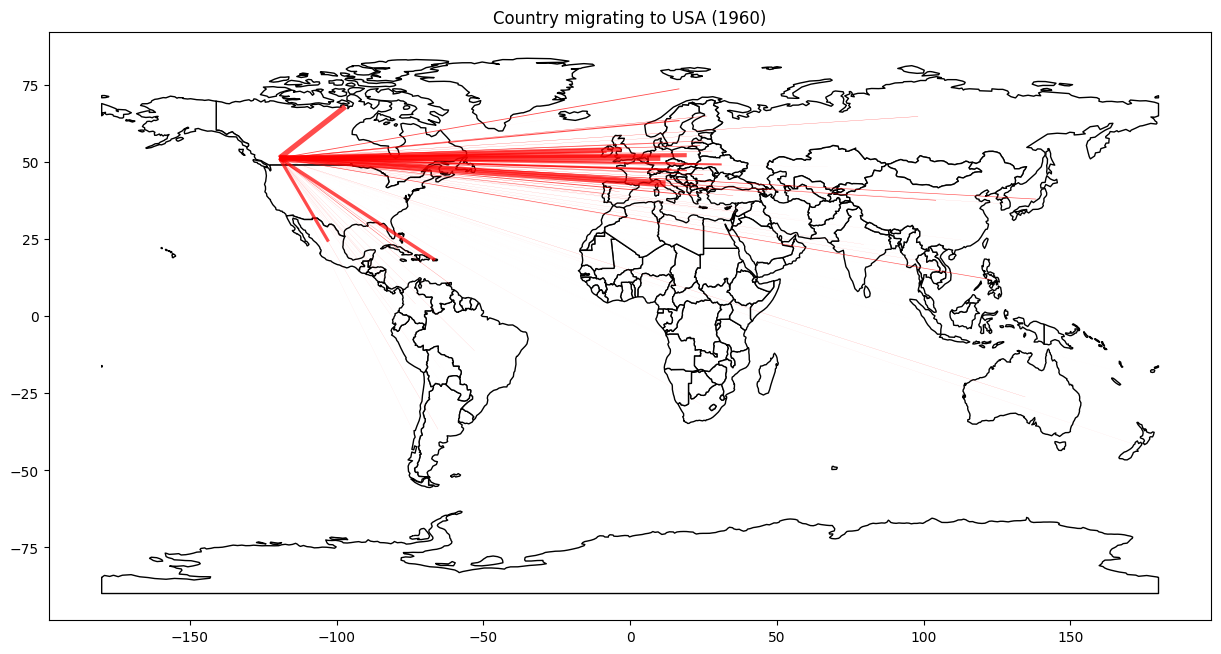

In [22]:
# Plot setup
fig, ax = plt.subplots(figsize=(15,10))

# 6.1 Plot the world map
world.plot(ax=ax, color='white', edgecolor='black')

# For example, define a scale factor
max_migration = gdf_edges['1960'].max()
scale_factor = 5.0 / max_migration  # tweak to taste

gdf_edges.plot(
    ax=ax,
    color='red',
    linewidth=gdf_edges['1960'] * scale_factor,
    alpha=0.7
)

plt.title("Country migrating to USA (1960)")
plt.show()


    country_code                     geometry
0            AFG    POINT (66.12826 33.93667)
1            ALB     POINT (20.03154 41.1538)
2            DZA     POINT (2.59661 28.44987)
5            AGO    POINT (17.4732 -12.30289)
8            ARG    POINT (-65.4182 -36.7045)
..           ...                          ...
211          VNM   POINT (106.26223 16.82176)
215          YEM    POINT (47.54565 15.92826)
216          ZMB   POINT (27.71108 -13.42741)
217          ZWE    POINT (29.78843 -18.9298)
0            USA  POINT (-119.45018 51.26001)

[166 rows x 2 columns]


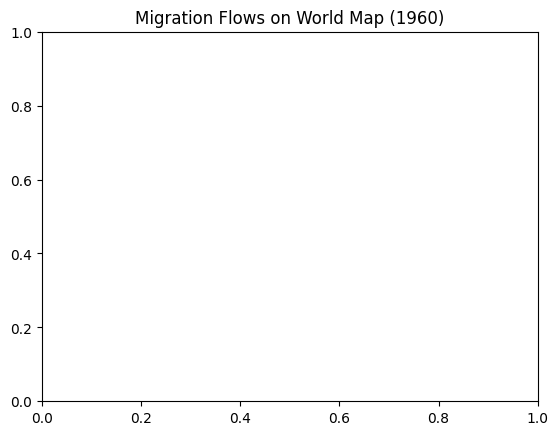

In [23]:
# -- (Optional) ADD NODE MARKERS BELOW -- #
# We gather all unique origin and destination points in a separate GeoDataFrame
all_points = []

# Extract origin points
tmp_orig = df_merged[['Origin_code', 'origin_centroid']].drop_duplicates()
tmp_orig = tmp_orig.rename(columns={
    'Origin_code': 'country_code',
    'origin_centroid': 'geometry'
})
all_points.append(tmp_orig)

# Extract destination points
tmp_dest = df_merged[['Destination_code', 'destination_centroid']].drop_duplicates()
tmp_dest = tmp_dest.rename(columns={
    'Destination_code': 'country_code',
    'destination_centroid': 'geometry'
})
all_points.append(tmp_dest)

# Concatenate origin & destination points, drop duplicates
df_points = pd.concat(all_points).drop_duplicates('country_code')
print(df_points)

# Make a GeoDataFrame
gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

# Finally, plot the points on top of the map and lines
gdf_points.plot(
    ax=ax,
    color='blue',
    markersize=30,  # Adjust as desired
    zorder=4        # Ensures markers appear above the lines
)

plt.title("Migration Flows on World Map (1960)")
plt.show()

In [55]:
# Extract all unique centroids
all_points = []

for c in ['Origin_code', 'Destination_code']:
    tmp = df_merged[[c, f'{c.lower()}_centroid']].drop_duplicates()
    tmp = tmp.rename(columns={
        c: 'country_code',
        f'{c.lower()}_centroid': 'geometry'
    })
    all_points.append(tmp)

# Combine them
df_points = pd.concat(all_points).drop_duplicates('country_code')

gdf_points = gpd.GeoDataFrame(df_points, geometry='geometry', crs="EPSG:4326")

# Plot points on the same map
gdf_points.plot(ax=ax, color='blue', markersize=10)


KeyError: "['origin_code_centroid'] not in index"

In [28]:
# Create a directed graph
G = nx.DiGraph()

# Add edges to the graph, with origin and destination as nodes
for _, row in both_gender_1960.iterrows():
    G.add_edge(row['Origin_name'], row['Destination_name'], weight=row['1960'])

Error retrieving coordinates for Venezuela, RB: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Venezuela%2C+RB&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error retrieving coordinates for Virgin Islands (U.S.): HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Virgin+Islands+%28U.S.%29&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error retrieving coordinates for Venezuela, RB: HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Max retries exceeded with url: /search?q=Venezuela%2C+RB&format=json&limit=1 (Caused by ReadTimeoutError("HTTPSConnectionPool(host='nominatim.openstreetmap.org', port=443): Read timed out. (read timeout=1)"))
Error retr

KeyboardInterrupt: 

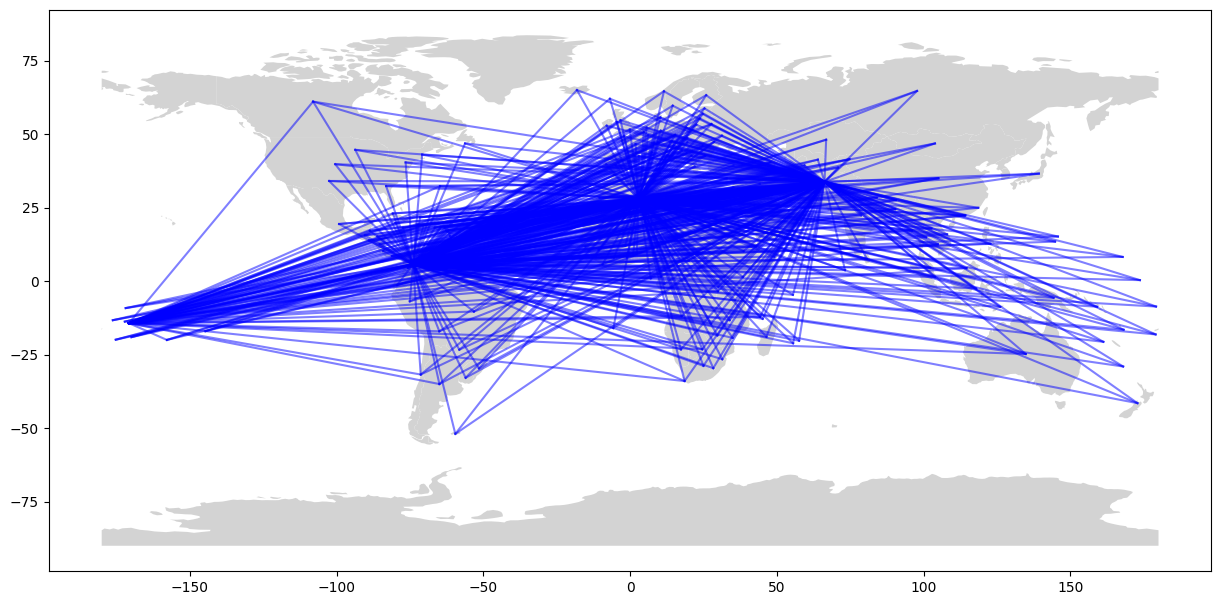

In [30]:
# Assuming you have your migration graph already created (G is your directed graph)

# Load the world map from a custom shapefile
shapefile_path = 'World_map/ne_110m_admin_0_countries.shp'
world = gpd.read_file(shapefile_path)

# Plot the world map
ax = world.plot(figsize=(15, 10), color='lightgrey')

# Add edges from the migration graph to the plot
for edge in G.edges():
    origin, destination = edge
    origin_coords = get_coordinates(origin)
    destination_coords = get_coordinates(destination)
    
    if origin_coords and destination_coords:
        # Plot the line between the origin and destination on the map
        plt.plot([origin_coords[1], destination_coords[1]], 
                 [origin_coords[0], destination_coords[0]], color='blue', alpha=0.5)

# Show the plot
plt.show()
